In [1]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import seaborn as sns
import pandas as pd


# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

model_dir = './models/'
model_file = model_dir + 'vg16_trf_learning.keras'

Keras = 2.15.0
Num GPUs Available:  1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! unzip -o drive/MyDrive/dataset_19.zip

! pwd

Archive:  drive/MyDrive/dataset_19.zip
   creating: dataset_19/glioma/
  inflating: dataset_19/glioma/Te-gl_0010.jpg  
  inflating: dataset_19/glioma/Te-gl_0016.jpg  
  inflating: dataset_19/glioma/Te-gl_0020.jpg  
  inflating: dataset_19/glioma/Te-gl_0026.jpg  
  inflating: dataset_19/glioma/Te-gl_0035.jpg  
  inflating: dataset_19/glioma/Te-gl_0041.jpg  
  inflating: dataset_19/glioma/Te-gl_0043.jpg  
  inflating: dataset_19/glioma/Te-gl_0044.jpg  
  inflating: dataset_19/glioma/Te-gl_0045.jpg  
  inflating: dataset_19/glioma/Te-gl_0057.jpg  
  inflating: dataset_19/glioma/Te-gl_0060.jpg  
  inflating: dataset_19/glioma/Te-gl_0075.jpg  
  inflating: dataset_19/glioma/Te-gl_0079.jpg  
  inflating: dataset_19/glioma/Te-gl_0085.jpg  
  inflating: dataset_19/glioma/Te-gl_0090.jpg  
  inflating: dataset_19/glioma/Te-gl_0107.jpg  
  inflating: dataset_19/glioma/Te-gl_0114.jpg  
  inflating: dataset_19/glioma/Te-gl_0125.jpg  
  inflating: dataset_19/glioma/Te-gl_0126.jpg  
  inflating: data

# Load the data

In [4]:
# Data Directories
dir = "dataset_19/"


## Data Distribution

In [ ]:
data_distribution_count = pd.Series(
    {curr_index: len(os.listdir(os.path.join(dir, curr_index))) for curr_index in os.listdir(dir)})

data_distribution_count

pituitary     120
notumor       120
meningioma    120
glioma        120
dtype: int64

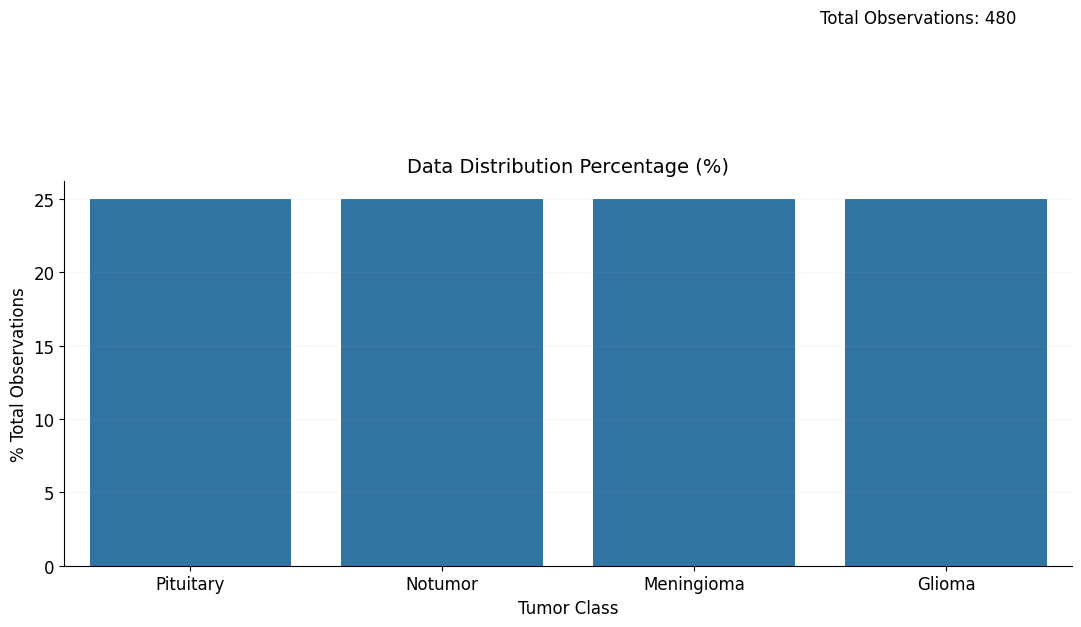

In [ ]:
fig, axis = plt.subplots(figsize=(13, 5))
axis.grid(True, alpha=0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize=14)
sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y=100 * data_distribution_count / data_distribution_count.sum(), ax=axis)
axis.set_xlabel("Tumor Class", fontsize=12)
axis.set_ylabel("% Total Observations", fontsize=12)
axis.tick_params(which='major', labelsize=12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
sns.despine()

## Splitting the data

In [7]:
classes = os.listdir(dir)

batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20,
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255,
                                        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    subset='training'
)

test_generator = validation_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    subset='validation')


print(test_generator.class_indices)

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# Training a VGG16 model

In [5]:
!pip install optuna optuna-integration

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.5 MB/s eta 0:00:00


In [9]:
import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import os

def create_vgg16_model(trial):
    input_shape = (224, 224, 3)
    num_classes = len(os.listdir(dir))  # Assuming the number of classes equals the number of directories

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)

    # Optimizing the number of dense layers
    n_dense_layers = trial.suggest_int('n_dense_layers', 0, 3)
    for i in range(n_dense_layers):
        units = trial.suggest_int(f'n_units_{i}', 256, 1024)
        x = Dense(units, activation='relu')(x)
        dropout_rate = trial.suggest_float(f'dropout_{i}', 0.2, 0.5)
        x = Dropout(dropout_rate)(x)

    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

def objective(trial):
    model = create_vgg16_model(trial)

    # checkpoint = ModelCheckpoint('vgg16_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
    pruning_callback = TFKerasPruningCallback(trial, 'val_loss')

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=80,
        validation_data=test_generator,
        validation_steps=test_generator.samples // test_generator.batch_size,
        callbacks=[early_stopping, reduce_lr, pruning_callback]
    )

    val_loss = min(history.history['val_loss'])
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=3600)

print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-06-05 10:02:21,381] A new study created in memory with name: no-name-e5f3cd87-32ea-4133-a780-1f26af44a4df
<ipython-input-9-3b03d6e20b7a>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch 1/80
24/24 [==============================] - 7s 216ms/step - loss: 1.3670 - accuracy: 0.3620 - val_loss: 1.2186 - val_accuracy: 0.4167 - lr: 1.5219e-04
Epoch 2/80
24/24 [==============================] - 7s 284ms/step - loss: 1.0182 - accuracy: 0.5417 - val_loss: 1.1158 - val_accuracy: 0.5104 - lr: 1.5219e-04
Epoch 3/80
24/24 [==============================] - 5s 219ms/step - loss: 0.8245 - accuracy: 0.6641 - val_loss: 1.0441 - val_accuracy: 0.5625 - lr: 1.5219e-04
Epoch 4/80
24/24 [==============================] - 7s 279ms/step - loss: 0.6895 - accuracy: 0.7188 - val_loss: 1.0110 - val_accuracy: 0.6146 - lr: 1.5219e-04
Epoch 5/80
24/24 [==============================] - 5s 209ms/step - loss: 0.6292 - accuracy: 0.7188 - val_loss: 0.9542 - val_accuracy: 0.6771 - lr: 1.5219e-04
Epoch 6/80
24/24 [==============================] - 5s 221ms/step - loss: 0.5325 - accuracy: 0.7917 - val_loss: 0.7791 - val_accuracy: 0.5938 - lr: 1.5219e-04
Epoch 7/80
24/24 [============================

[I 2024-06-05 10:05:03,546] Trial 0 finished with value: 0.7754748463630676 and parameters: {'n_dense_layers': 3, 'n_units_0': 273, 'dropout_0': 0.4728111543470944, 'n_units_1': 962, 'dropout_1': 0.2230203257818001, 'n_units_2': 985, 'dropout_2': 0.23991802632904471, 'learning_rate': 0.00015218674187250696}. Best is trial 0 with value: 0.7754748463630676.


Epoch 1/80
24/24 [==============================] - 7s 240ms/step - loss: 1.4883 - accuracy: 0.3464 - val_loss: 1.1811 - val_accuracy: 0.5000 - lr: 1.5654e-05
Epoch 2/80
24/24 [==============================] - 5s 223ms/step - loss: 1.0989 - accuracy: 0.5339 - val_loss: 1.1021 - val_accuracy: 0.5000 - lr: 1.5654e-05
Epoch 3/80
24/24 [==============================] - 7s 277ms/step - loss: 0.9555 - accuracy: 0.6250 - val_loss: 1.0470 - val_accuracy: 0.4792 - lr: 1.5654e-05
Epoch 4/80
24/24 [==============================] - 5s 215ms/step - loss: 0.8208 - accuracy: 0.6823 - val_loss: 1.0523 - val_accuracy: 0.5417 - lr: 1.5654e-05
Epoch 5/80
24/24 [==============================] - 6s 232ms/step - loss: 0.7454 - accuracy: 0.6979 - val_loss: 0.9893 - val_accuracy: 0.5729 - lr: 1.5654e-05
Epoch 6/80
24/24 [==============================] - 6s 252ms/step - loss: 0.7562 - accuracy: 0.7240 - val_loss: 0.9211 - val_accuracy: 0.6458 - lr: 1.5654e-05
Epoch 7/80
24/24 [============================

[I 2024-06-05 10:07:50,074] Trial 1 finished with value: 0.7489092350006104 and parameters: {'n_dense_layers': 2, 'n_units_0': 944, 'dropout_0': 0.44629016986300885, 'n_units_1': 329, 'dropout_1': 0.329384883072916, 'learning_rate': 1.5653941582415394e-05}. Best is trial 1 with value: 0.7489092350006104.


Epoch 1/80
24/24 [==============================] - 8s 274ms/step - loss: 1.0664 - accuracy: 0.5286 - val_loss: 1.1356 - val_accuracy: 0.5312 - lr: 8.7175e-05
Epoch 2/80
24/24 [==============================] - 5s 217ms/step - loss: 0.7096 - accuracy: 0.7214 - val_loss: 0.9002 - val_accuracy: 0.6146 - lr: 8.7175e-05
Epoch 3/80
24/24 [==============================] - 5s 227ms/step - loss: 0.5166 - accuracy: 0.8229 - val_loss: 0.7841 - val_accuracy: 0.6667 - lr: 8.7175e-05
Epoch 4/80
24/24 [==============================] - 6s 252ms/step - loss: 0.4807 - accuracy: 0.8125 - val_loss: 0.8669 - val_accuracy: 0.6979 - lr: 8.7175e-05
Epoch 5/80
24/24 [==============================] - 5s 217ms/step - loss: 0.3535 - accuracy: 0.8750 - val_loss: 0.7938 - val_accuracy: 0.6979 - lr: 8.7175e-05
Epoch 6/80
24/24 [==============================] - ETA: 0s - loss: 0.3284 - accuracy: 0.8854
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.7435011977795514e-05.
24/24 [===========================

[I 2024-06-05 10:10:22,760] Trial 2 finished with value: 0.7169427275657654 and parameters: {'n_dense_layers': 2, 'n_units_0': 567, 'dropout_0': 0.21462994005235558, 'n_units_1': 761, 'dropout_1': 0.20554471730869353, 'learning_rate': 8.717505627586451e-05}. Best is trial 2 with value: 0.7169427275657654.


Epoch 1/80
24/24 [==============================] - 8s 259ms/step - loss: 1.1921 - accuracy: 0.5052 - val_loss: 1.2192 - val_accuracy: 0.4896 - lr: 1.0998e-04
Epoch 2/80
24/24 [==============================] - 5s 215ms/step - loss: 0.8456 - accuracy: 0.6823 - val_loss: 1.1715 - val_accuracy: 0.5312 - lr: 1.0998e-04
Epoch 3/80
24/24 [==============================] - 7s 282ms/step - loss: 0.6828 - accuracy: 0.7917 - val_loss: 1.0477 - val_accuracy: 0.5312 - lr: 1.0998e-04
Epoch 4/80
24/24 [==============================] - 5s 225ms/step - loss: 0.6041 - accuracy: 0.8073 - val_loss: 0.9413 - val_accuracy: 0.5938 - lr: 1.0998e-04
Epoch 5/80
24/24 [==============================] - 5s 223ms/step - loss: 0.5498 - accuracy: 0.8177 - val_loss: 0.8591 - val_accuracy: 0.6354 - lr: 1.0998e-04
Epoch 6/80
24/24 [==============================] - 7s 275ms/step - loss: 0.4843 - accuracy: 0.8568 - val_loss: 0.8061 - val_accuracy: 0.6667 - lr: 1.0998e-04
Epoch 7/80
24/24 [============================

[I 2024-06-05 10:13:39,284] Trial 3 finished with value: 0.6401606202125549 and parameters: {'n_dense_layers': 0, 'learning_rate': 0.00010998429393257916}. Best is trial 3 with value: 0.6401606202125549.


Epoch 1/80
24/24 [==============================] - 8s 236ms/step - loss: 4.1808 - accuracy: 0.3229 - val_loss: 2.6406 - val_accuracy: 0.3646 - lr: 9.3703e-04
Epoch 2/80
24/24 [==============================] - 5s 216ms/step - loss: 1.9270 - accuracy: 0.5000 - val_loss: 1.5183 - val_accuracy: 0.5521 - lr: 9.3703e-04
Epoch 3/80
24/24 [==============================] - 7s 273ms/step - loss: 0.9491 - accuracy: 0.6432 - val_loss: 0.9790 - val_accuracy: 0.5208 - lr: 9.3703e-04
Epoch 4/80
24/24 [==============================] - 5s 215ms/step - loss: 0.6722 - accuracy: 0.7344 - val_loss: 0.8491 - val_accuracy: 0.5938 - lr: 9.3703e-04
Epoch 5/80
24/24 [==============================] - 5s 217ms/step - loss: 0.6092 - accuracy: 0.7604 - val_loss: 0.8354 - val_accuracy: 0.6562 - lr: 9.3703e-04
Epoch 6/80
24/24 [==============================] - 7s 272ms/step - loss: 0.5426 - accuracy: 0.7812 - val_loss: 0.8541 - val_accuracy: 0.6354 - lr: 9.3703e-04
Epoch 7/80
24/24 [============================

[I 2024-06-05 10:15:58,301] Trial 4 finished with value: 0.6396509408950806 and parameters: {'n_dense_layers': 3, 'n_units_0': 934, 'dropout_0': 0.2720638559962729, 'n_units_1': 696, 'dropout_1': 0.46730701800223073, 'n_units_2': 740, 'dropout_2': 0.4328432388354497, 'learning_rate': 0.0009370299895209238}. Best is trial 4 with value: 0.6396509408950806.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.4773 - accuracy: 0.3125

[I 2024-06-05 10:16:06,590] Trial 5 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - 7s 262ms/step - loss: 1.2294 - accuracy: 0.4766 - val_loss: 1.1486 - val_accuracy: 0.4896 - lr: 2.1611e-04
Epoch 2/80
24/24 [==============================] - 5s 222ms/step - loss: 0.6815 - accuracy: 0.7500 - val_loss: 0.9782 - val_accuracy: 0.5833 - lr: 2.1611e-04
Epoch 3/80
24/24 [==============================] - 5s 222ms/step - loss: 0.5439 - accuracy: 0.8307 - val_loss: 0.9091 - val_accuracy: 0.6146 - lr: 2.1611e-04
Epoch 4/80
24/24 [==============================] - 6s 242ms/step - loss: 0.4614 - accuracy: 0.8516 - val_loss: 0.7802 - val_accuracy: 0.6354 - lr: 2.1611e-04
Epoch 5/80
24/24 [==============================] - 7s 285ms/step - loss: 0.4005 - accuracy: 0.8802 - val_loss: 0.8197 - val_accuracy: 0.7083 - lr: 2.1611e-04
Epoch 6/80
24/24 [==============================] - 5s 211ms/step - loss: 0.3351 - accuracy: 0.9036 - val_loss: 0.7195 - val_accuracy: 0.7396 - lr: 2.1611e-04
Epoch 7/80
24/24 [============================

[I 2024-06-05 10:19:07,126] Trial 6 finished with value: 0.6495966911315918 and parameters: {'n_dense_layers': 0, 'learning_rate': 0.0002161073494688127}. Best is trial 4 with value: 0.6396509408950806.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.4447 - accuracy: 0.2474

[I 2024-06-05 10:19:16,529] Trial 7 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.3548 - accuracy: 0.3568

[I 2024-06-05 10:19:24,329] Trial 8 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.3631 - accuracy: 0.3255

[I 2024-06-05 10:19:33,103] Trial 9 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 2.9236 - accuracy: 0.5234

[I 2024-06-05 10:19:40,770] Trial 10 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 3.1088 - accuracy: 0.4740

[I 2024-06-05 10:19:48,457] Trial 11 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.8347 - accuracy: 0.4870

[I 2024-06-05 10:19:56,891] Trial 12 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.3433 - accuracy: 0.4271

[I 2024-06-05 10:20:03,663] Trial 13 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 2.1263 - accuracy: 0.4661

[I 2024-06-05 10:20:13,120] Trial 14 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 4.1190 - accuracy: 0.5260

[I 2024-06-05 10:20:20,261] Trial 15 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.3735 - accuracy: 0.3047

[I 2024-06-05 10:20:28,440] Trial 16 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 2.5987 - accuracy: 0.3646

[I 2024-06-05 10:20:37,271] Trial 17 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.3595 - accuracy: 0.4557

[I 2024-06-05 10:20:44,922] Trial 18 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - 8s 281ms/step - loss: 2.0365 - accuracy: 0.4948 - val_loss: 1.1088 - val_accuracy: 0.5938 - lr: 2.2303e-04
Epoch 2/80
24/24 [==============================] - 5s 213ms/step - loss: 0.7577 - accuracy: 0.7161 - val_loss: 0.9063 - val_accuracy: 0.6354 - lr: 2.2303e-04
Epoch 3/80
24/24 [==============================] - 6s 263ms/step - loss: 0.4948 - accuracy: 0.8177 - val_loss: 0.7672 - val_accuracy: 0.7292 - lr: 2.2303e-04
Epoch 4/80
24/24 [==============================] - 5s 226ms/step - loss: 0.3243 - accuracy: 0.8906 - val_loss: 0.6814 - val_accuracy: 0.7292 - lr: 2.2303e-04
Epoch 5/80
24/24 [==============================] - 5s 219ms/step - loss: 0.3244 - accuracy: 0.8646 - val_loss: 0.6626 - val_accuracy: 0.7188 - lr: 2.2303e-04
Epoch 6/80
24/24 [==============================] - 5s 222ms/step - loss: 0.2889 - accuracy: 0.8854 - val_loss: 0.6777 - val_accuracy: 0.7604 - lr: 2.2303e-04
Epoch 7/80
24/24 [============================

[I 2024-06-05 10:22:50,331] Trial 19 finished with value: 0.6626160740852356 and parameters: {'n_dense_layers': 1, 'n_units_0': 885, 'dropout_0': 0.4141780154778288, 'learning_rate': 0.0002230340801710483}. Best is trial 4 with value: 0.6396509408950806.


Epoch 1/80
24/24 [==============================] - 6s 220ms/step - loss: 1.2950 - accuracy: 0.4714 - val_loss: 1.1695 - val_accuracy: 0.5104 - lr: 5.7401e-05
Epoch 2/80
24/24 [==============================] - ETA: 0s - loss: 0.9785 - accuracy: 0.6432

[I 2024-06-05 10:23:07,106] Trial 20 pruned. Trial was pruned at epoch 1.


Epoch 1/80
24/24 [==============================] - 7s 270ms/step - loss: 1.2325 - accuracy: 0.4792 - val_loss: 1.0658 - val_accuracy: 0.4688 - lr: 1.6171e-04
Epoch 2/80
24/24 [==============================] - 5s 214ms/step - loss: 0.7545 - accuracy: 0.7109 - val_loss: 0.9927 - val_accuracy: 0.5521 - lr: 1.6171e-04
Epoch 3/80
24/24 [==============================] - 5s 216ms/step - loss: 0.6019 - accuracy: 0.8047 - val_loss: 0.9022 - val_accuracy: 0.6458 - lr: 1.6171e-04
Epoch 4/80
24/24 [==============================] - ETA: 0s - loss: 0.5389 - accuracy: 0.7943

[I 2024-06-05 10:23:31,933] Trial 21 pruned. Trial was pruned at epoch 3.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.1271 - accuracy: 0.5339

[I 2024-06-05 10:23:38,593] Trial 22 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - 8s 259ms/step - loss: 1.0132 - accuracy: 0.5547 - val_loss: 1.0868 - val_accuracy: 0.6458 - lr: 5.0350e-04
Epoch 2/80
24/24 [==============================] - 5s 212ms/step - loss: 0.5587 - accuracy: 0.7943 - val_loss: 0.8448 - val_accuracy: 0.6250 - lr: 5.0350e-04
Epoch 3/80
24/24 [==============================] - 5s 224ms/step - loss: 0.3450 - accuracy: 0.8932 - val_loss: 0.7105 - val_accuracy: 0.7188 - lr: 5.0350e-04
Epoch 4/80
24/24 [==============================] - 7s 273ms/step - loss: 0.2787 - accuracy: 0.9323 - val_loss: 0.7266 - val_accuracy: 0.7083 - lr: 5.0350e-04
Epoch 5/80
24/24 [==============================] - 5s 215ms/step - loss: 0.2680 - accuracy: 0.9010 - val_loss: 0.7492 - val_accuracy: 0.7292 - lr: 5.0350e-04
Epoch 6/80
24/24 [==============================] - 7s 269ms/step - loss: 0.2245 - accuracy: 0.9401 - val_loss: 0.6848 - val_accuracy: 0.7604 - lr: 5.0350e-04
Epoch 7/80
24/24 [============================

[I 2024-06-05 10:26:13,773] Trial 23 finished with value: 0.6559492945671082 and parameters: {'n_dense_layers': 0, 'learning_rate': 0.0005035027419504152}. Best is trial 4 with value: 0.6396509408950806.


Epoch 1/80
24/24 [==============================] - 8s 283ms/step - loss: 1.0698 - accuracy: 0.5677 - val_loss: 0.8722 - val_accuracy: 0.6146 - lr: 9.7945e-05
Epoch 2/80
24/24 [==============================] - 5s 221ms/step - loss: 0.5423 - accuracy: 0.7630 - val_loss: 0.7468 - val_accuracy: 0.7083 - lr: 9.7945e-05
Epoch 3/80
24/24 [==============================] - 7s 286ms/step - loss: 0.4489 - accuracy: 0.8359 - val_loss: 0.9110 - val_accuracy: 0.6458 - lr: 9.7945e-05
Epoch 4/80
24/24 [==============================] - 5s 212ms/step - loss: 0.3444 - accuracy: 0.8698 - val_loss: 0.6384 - val_accuracy: 0.7500 - lr: 9.7945e-05
Epoch 5/80
24/24 [==============================] - 6s 271ms/step - loss: 0.2685 - accuracy: 0.8906 - val_loss: 0.8708 - val_accuracy: 0.6562 - lr: 9.7945e-05
Epoch 6/80
24/24 [==============================] - 5s 215ms/step - loss: 0.2723 - accuracy: 0.8932 - val_loss: 0.7266 - val_accuracy: 0.7396 - lr: 9.7945e-05
Epoch 7/80
24/24 [============================

[I 2024-06-05 10:27:51,397] Trial 24 finished with value: 0.6383881568908691 and parameters: {'n_dense_layers': 1, 'n_units_0': 468, 'dropout_0': 0.3302568206555625, 'learning_rate': 9.794513709954874e-05}. Best is trial 24 with value: 0.6383881568908691.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.2394 - accuracy: 0.4453

[I 2024-06-05 10:28:00,026] Trial 25 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - 7s 235ms/step - loss: 1.2231 - accuracy: 0.4896 - val_loss: 1.0740 - val_accuracy: 0.4688 - lr: 5.7935e-05
Epoch 2/80
24/24 [==============================] - 6s 257ms/step - loss: 0.6700 - accuracy: 0.7344 - val_loss: 0.8996 - val_accuracy: 0.6250 - lr: 5.7935e-05
Epoch 3/80
24/24 [==============================] - 5s 217ms/step - loss: 0.4707 - accuracy: 0.8490 - val_loss: 0.7508 - val_accuracy: 0.6562 - lr: 5.7935e-05
Epoch 4/80
24/24 [==============================] - 7s 280ms/step - loss: 0.3794 - accuracy: 0.8646 - val_loss: 0.7104 - val_accuracy: 0.6667 - lr: 5.7935e-05
Epoch 5/80
24/24 [==============================] - 5s 211ms/step - loss: 0.3206 - accuracy: 0.8828 - val_loss: 0.7265 - val_accuracy: 0.6354 - lr: 5.7935e-05
Epoch 6/80
24/24 [==============================] - 6s 253ms/step - loss: 0.3181 - accuracy: 0.8958 - val_loss: 0.7811 - val_accuracy: 0.6979 - lr: 5.7935e-05
Epoch 7/80
24/24 [============================

[I 2024-06-05 10:30:06,865] Trial 26 finished with value: 0.6567661166191101 and parameters: {'n_dense_layers': 1, 'n_units_0': 510, 'dropout_0': 0.29259118748937274, 'learning_rate': 5.7934817465859325e-05}. Best is trial 24 with value: 0.6383881568908691.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.3223 - accuracy: 0.4115

[I 2024-06-05 10:30:15,702] Trial 27 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.5873 - accuracy: 0.3385

[I 2024-06-05 10:30:27,913] Trial 28 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.4706 - accuracy: 0.3385

[I 2024-06-05 10:30:39,186] Trial 29 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - 7s 216ms/step - loss: 1.1178 - accuracy: 0.5443 - val_loss: 1.0693 - val_accuracy: 0.5000 - lr: 6.0569e-05
Epoch 2/80
24/24 [==============================] - ETA: 0s - loss: 0.6410 - accuracy: 0.7396

[I 2024-06-05 10:30:58,119] Trial 30 pruned. Trial was pruned at epoch 1.


Epoch 1/80
24/24 [==============================] - 6s 226ms/step - loss: 1.0892 - accuracy: 0.5547 - val_loss: 1.1164 - val_accuracy: 0.4479 - lr: 2.3696e-04
Epoch 2/80
24/24 [==============================] - 7s 283ms/step - loss: 0.6585 - accuracy: 0.7370 - val_loss: 0.9369 - val_accuracy: 0.6042 - lr: 2.3696e-04
Epoch 3/80
24/24 [==============================] - 5s 211ms/step - loss: 0.5061 - accuracy: 0.8333 - val_loss: 0.8441 - val_accuracy: 0.6146 - lr: 2.3696e-04
Epoch 4/80
24/24 [==============================] - 5s 222ms/step - loss: 0.4244 - accuracy: 0.8750 - val_loss: 0.7858 - val_accuracy: 0.6667 - lr: 2.3696e-04
Epoch 5/80
24/24 [==============================] - 6s 261ms/step - loss: 0.3641 - accuracy: 0.8880 - val_loss: 0.7369 - val_accuracy: 0.6562 - lr: 2.3696e-04
Epoch 6/80
24/24 [==============================] - 5s 214ms/step - loss: 0.3033 - accuracy: 0.9245 - val_loss: 0.7641 - val_accuracy: 0.7083 - lr: 2.3696e-04
Epoch 7/80
24/24 [============================

[I 2024-06-05 10:32:58,715] Trial 31 finished with value: 0.6650270819664001 and parameters: {'n_dense_layers': 0, 'learning_rate': 0.00023696279205804056}. Best is trial 24 with value: 0.6383881568908691.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.1124 - accuracy: 0.5286

[I 2024-06-05 10:33:10,340] Trial 32 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.2286 - accuracy: 0.4661

[I 2024-06-05 10:33:21,766] Trial 33 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - 8s 247ms/step - loss: 1.4130 - accuracy: 0.5156 - val_loss: 0.8633 - val_accuracy: 0.6562 - lr: 3.5099e-04
Epoch 2/80
24/24 [==============================] - 5s 216ms/step - loss: 0.5279 - accuracy: 0.7839 - val_loss: 0.6948 - val_accuracy: 0.6979 - lr: 3.5099e-04
Epoch 3/80
24/24 [==============================] - 7s 283ms/step - loss: 0.4156 - accuracy: 0.8438 - val_loss: 0.7122 - val_accuracy: 0.7083 - lr: 3.5099e-04
Epoch 4/80
24/24 [==============================] - 5s 210ms/step - loss: 0.3021 - accuracy: 0.9036 - val_loss: 0.7549 - val_accuracy: 0.6979 - lr: 3.5099e-04
Epoch 5/80
24/24 [==============================] - ETA: 0s - loss: 0.3207 - accuracy: 0.8750
Epoch 5: ReduceLROnPlateau reducing learning rate to 7.019879412837327e-05.
24/24 [==============================] - 6s 269ms/step - loss: 0.3207 - accuracy: 0.8750 - val_loss: 0.7663 - val_accuracy: 0.7604 - lr: 3.5099e-04
Epoch 6/80
24/24 [============================

[I 2024-06-05 10:35:18,704] Trial 34 pruned. Trial was pruned at epoch 15.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.2117 - accuracy: 0.4505

[I 2024-06-05 10:35:26,377] Trial 35 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.4751 - accuracy: 0.3568

[I 2024-06-05 10:35:38,016] Trial 36 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.5344 - accuracy: 0.3099

[I 2024-06-05 10:35:46,395] Trial 37 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - 7s 272ms/step - loss: 1.1646 - accuracy: 0.5078 - val_loss: 1.1043 - val_accuracy: 0.4271 - lr: 1.9156e-04
Epoch 2/80
24/24 [==============================] - ETA: 0s - loss: 0.7278 - accuracy: 0.7292

[I 2024-06-05 10:36:03,266] Trial 38 pruned. Trial was pruned at epoch 1.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.3820 - accuracy: 0.3464

[I 2024-06-05 10:36:12,631] Trial 39 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 3.2671 - accuracy: 0.4974

[I 2024-06-05 10:36:20,354] Trial 40 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.1306 - accuracy: 0.5703

[I 2024-06-05 10:36:27,814] Trial 41 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.3121 - accuracy: 0.5469

[I 2024-06-05 10:36:36,948] Trial 42 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 0.9519 - accuracy: 0.6198

[I 2024-06-05 10:36:43,788] Trial 43 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - 8s 288ms/step - loss: 1.2230 - accuracy: 0.5469 - val_loss: 1.0809 - val_accuracy: 0.5833 - lr: 6.3509e-04
Epoch 2/80
24/24 [==============================] - 5s 211ms/step - loss: 0.5470 - accuracy: 0.7682 - val_loss: 0.8119 - val_accuracy: 0.6771 - lr: 6.3509e-04
Epoch 3/80
24/24 [==============================] - 6s 262ms/step - loss: 0.3393 - accuracy: 0.8828 - val_loss: 0.6888 - val_accuracy: 0.7083 - lr: 6.3509e-04
Epoch 4/80
24/24 [==============================] - 5s 225ms/step - loss: 0.2749 - accuracy: 0.8958 - val_loss: 0.7514 - val_accuracy: 0.7083 - lr: 6.3509e-04
Epoch 5/80
24/24 [==============================] - 7s 285ms/step - loss: 0.2520 - accuracy: 0.9245 - val_loss: 0.8355 - val_accuracy: 0.6979 - lr: 6.3509e-04
Epoch 6/80
24/24 [==============================] - ETA: 0s - loss: 0.1841 - accuracy: 0.9453
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001270184526219964.
24/24 [============================

[I 2024-06-05 10:38:41,359] Trial 44 pruned. Trial was pruned at epoch 15.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 4.1457 - accuracy: 0.5104

[I 2024-06-05 10:38:48,929] Trial 45 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - 7s 228ms/step - loss: 1.0366 - accuracy: 0.5573 - val_loss: 1.0798 - val_accuracy: 0.5521 - lr: 3.0381e-04
Epoch 2/80
24/24 [==============================] - 5s 222ms/step - loss: 0.6780 - accuracy: 0.7292 - val_loss: 0.8777 - val_accuracy: 0.5625 - lr: 3.0381e-04
Epoch 3/80
24/24 [==============================] - 7s 270ms/step - loss: 0.4806 - accuracy: 0.8255 - val_loss: 0.8294 - val_accuracy: 0.6875 - lr: 3.0381e-04
Epoch 4/80
24/24 [==============================] - ETA: 0s - loss: 0.4219 - accuracy: 0.8490

[I 2024-06-05 10:39:18,376] Trial 46 pruned. Trial was pruned at epoch 3.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.6185 - accuracy: 0.5547

[I 2024-06-05 10:39:25,809] Trial 47 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.0793 - accuracy: 0.5365

[I 2024-06-05 10:39:33,952] Trial 48 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.4510 - accuracy: 0.3464

[I 2024-06-05 10:39:41,631] Trial 49 pruned. Trial was pruned at epoch 0.


Best trial:
  Value: 0.6383881568908691
  Params: 
    n_dense_layers: 1
    n_units_0: 468
    dropout_0: 0.3302568206555625
    learning_rate: 9.794513709954874e-05


In [10]:
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Dense, Flatten
from keras.utils import plot_model
from tensorflow.keras.applications import VGG16

def VGG16_trf_learning(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)

    # Use the best parameters found
    x = Dense(468, activation='relu')(x)
    x = Dropout(0.3302568206555625)(x)

    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    learning_rate = 9.794513709954874e-05
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Check if the model exists
if os.path.exists(model_file):
    # Load the model from the file
    model = load_model(model_file)
else:
    # Create a new model
    model = VGG16_trf_learning((224, 224, 3), len(classes))

plot_model(model, to_file= 'model.png', show_shapes=True, show_layer_names=True)

model.summary()

Model: "model_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_57 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

# Train the model

In [11]:
from keras.callbacks import *

# Define callbacks
checkpoint = ModelCheckpoint(model_file, monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=80,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.0906 - accuracy: 0.5365
Epoch 1: val_loss improved from inf to 0.99797, saving model to ./models/vg16_trf_learning.keras
24/24 [==============================] - 9s 313ms/step - loss: 1.0906 - accuracy: 0.5365 - val_loss: 0.9980 - val_accuracy: 0.6250 - lr: 9.7945e-05
Epoch 2/80
24/24 [==============================] - ETA: 0s - loss: 0.6168 - accuracy: 0.7604
Epoch 2: val_loss improved from 0.99797 to 0.81261, saving model to ./models/vg16_trf_learning.keras
24/24 [==============================] - 6s 261ms/step - loss: 0.6168 - accuracy: 0.7604 - val_loss: 0.8126 - val_accuracy: 0.6562 - lr: 9.7945e-05
Epoch 3/80
24/24 [==============================] - ETA: 0s - loss: 0.4480 - accuracy: 0.8359
Epoch 3: val_loss improved from 0.81261 to 0.74041, saving model to ./models/vg16_trf_learning.keras
24/24 [==============================] - 7s 314ms/step - loss: 0.4480 - accuracy: 0.8359 - val_loss: 0.7404 - val_accuracy:

# Testing the Model

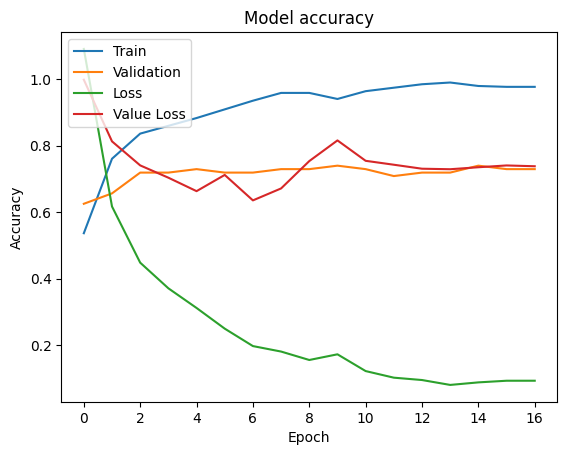

In [12]:
# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','Loss', 'Value Loss'], loc='upper left')
plt.show()

6/6 [==============================] - 0s 57ms/step


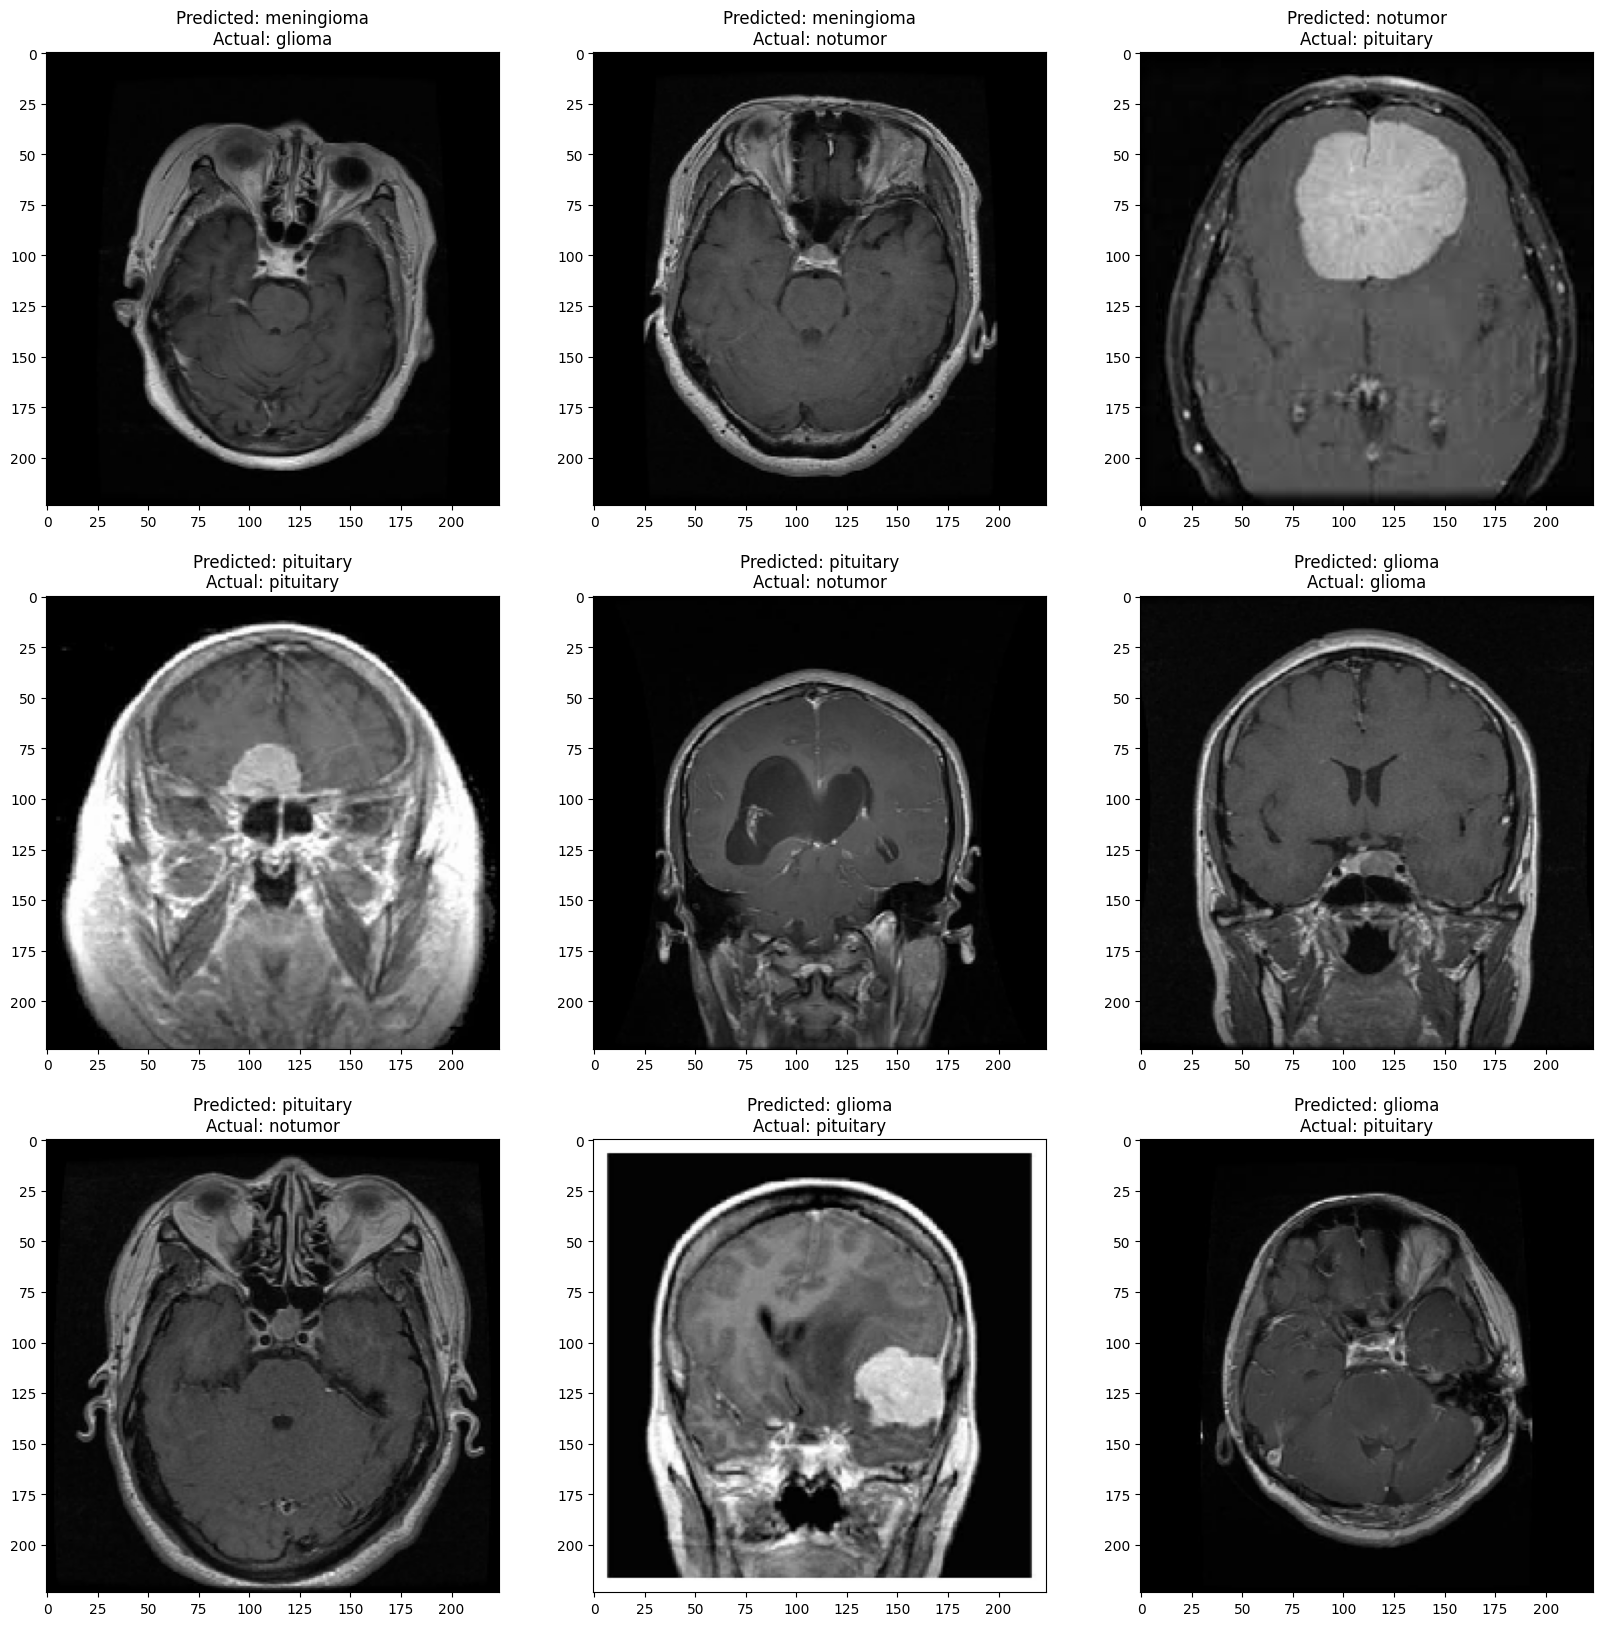

In [14]:
# Validate the model with test data

model = keras.models.load_model(model_file)
model.evaluate(test_generator)

# Predict the output
predictions = model.predict(test_generator)
predictions = np.argmax(predictions, axis=1)

# Predict and Display image using matplotlib
plt.figure(figsize=(20, 20))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    for X_batch, Y_batch in test_generator:
        image = X_batch[0]
        # Print Class
        plt.title("Predicted: " + classes[predictions[i]] + "\nActual: " + classes[np.argmax(Y_batch[i])])

        plt.imshow(image)
        break


# Model Visualisation (Evaluation)

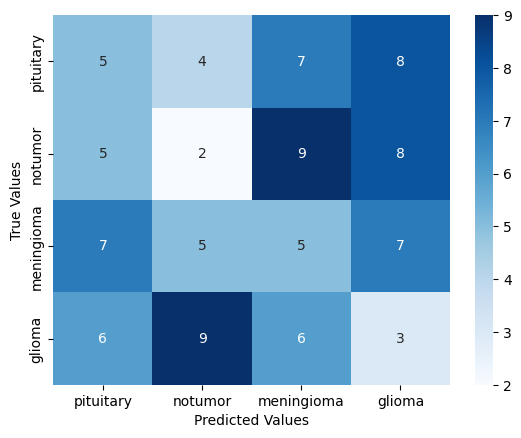

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_generator.classes, predictions)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');


In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score

def calculate_metrics(y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate metrics for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return dsc, sensitivity, specificity, accuracy

# Usage:
dsc, sensitivity, specificity, accuracy = calculate_metrics(test_generator.classes, predictions)
print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")

DSC: 0.1549383699321121, Sensitivity: 0.15625, Specificity: 0.71875, Accuracy: 0.15625
